# Electrophysiological Properties

Describing a basic set of electrophysiological properties in the morphologically-detailed models

# 1. FI-curve

### Basket Cell

In [1]:
# need to restart the kernel
from electrophysiological_props import Cell, FIcurve_plot, FIcurve_sim
ID = '864691135396580129_296758' # Basket Cell example
cell = Cell(ID=ID, 
            params_key='BC', # Basket Parameters
            passive_only=False, 
            with_axon=False)
results = FIcurve_sim(cell, AMPS=[-0.05, 0.15, 0.25, 0.35, 0.45, 0.55])

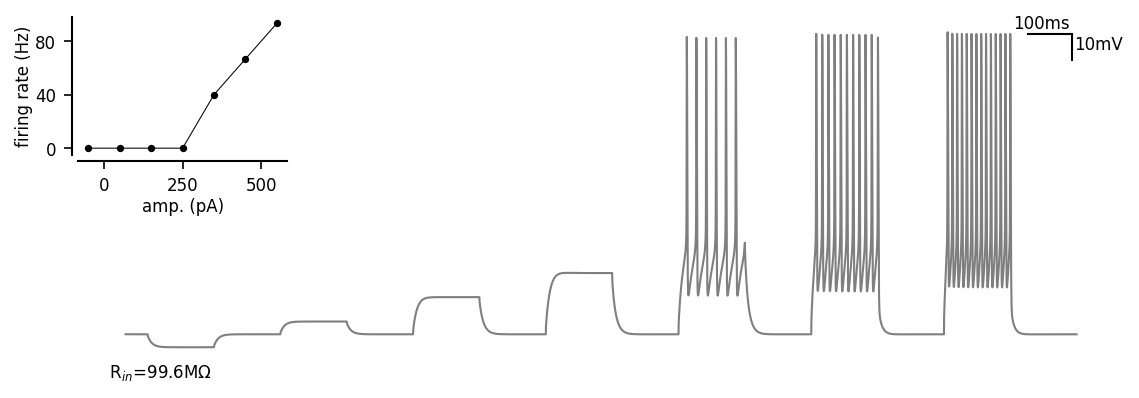

In [2]:
fig = FIcurve_plot(results)
fig.savefig('../../figures/FI-curve_BC.svg')

### Martinotti Cell

In [1]:
# need to restart the kernel
from electrophysiological_props import Cell, FIcurve_plot, FIcurve_sim
ID = '864691135571546917_264824' # Martinotti Cell
cell = Cell(ID=ID, 
            params_key='MC', # Martinotti Parameters
            passive_only=False, 
            with_axon=False)
results = FIcurve_sim(cell, AMPS=[-0.025, 0.1, 0.2, 0.3, 0.4])

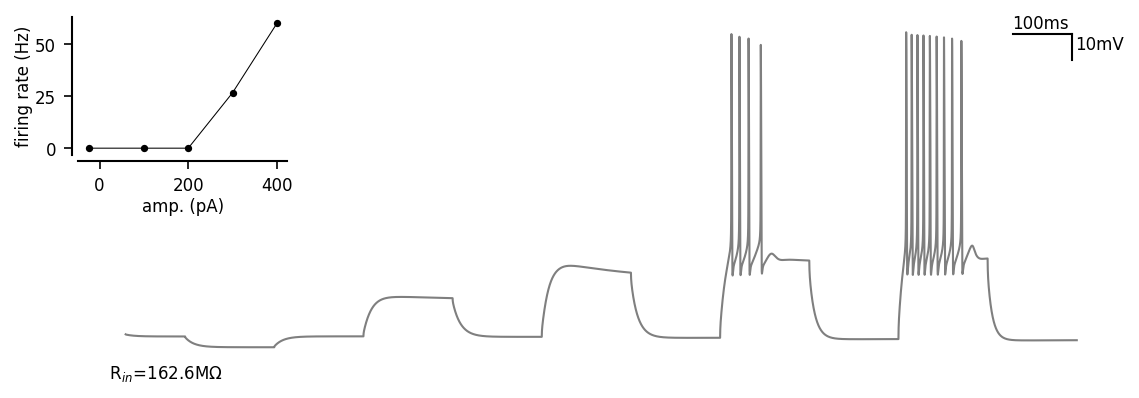

In [2]:
fig = FIcurve_plot(results)
fig.savefig('../../figures/FI-curve_MC.svg')

# 2. Resistance Profile

### Basket Cell

In [ ]:
from electrophysiological_props import Cell, resistance_profile, np
ID = '864691135396580129_296758' # Basket Cell example
cell = Cell(ID=ID, 
            params_key='BC', # Basket Parameters
            passive_only=True, 
            with_axon=False)
results = resistance_profile(cell)
np.save('../../data/detailed_model/Input-Resistance_BC.npy', results)

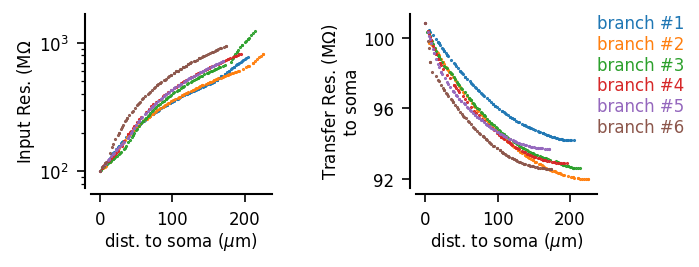

In [9]:
from electrophysiological_props import plt, pt, np
R = np.load('../../data/detailed_model/Input-Resistance_BC.npy',
            allow_pickle=True).item()

bins = np.linspace(0, 180, 20)
fig, AX = plt.subplots(1, 2, figsize=(5,2))
plt.subplots_adjust(wspace=0.8, bottom=0.3, right=0.8)
for i, dist, rin, rt in zip(range(len(R['Rt'])), R['distance'], R['Rin'], R['Rt']):
    AX[0].plot(dist, rin, 'o', ms=0.5, color=plt.cm.tab10(i))
    AX[1].plot(dist, rt, 'o', ms=0.5, color=plt.cm.tab10(i))
    pt.annotate(AX[1], i*'\n'+'branch #%i' % (i+1), (1,1), va='top', color=plt.cm.tab10(i))
pt.set_plot(AX[0], xlabel='dist. to soma ($\mu$m)',
            ylabel='Input Res. (M$\Omega$', yscale='log')
pt.set_plot(AX[1], xlabel='dist. to soma ($\mu$m)',
            ylabel='Transfer Res. (M$\Omega$)\n to soma ')
fig.savefig('../../figures/detailed_model/Resistance-Profile_BC.svg')

### Martinotti Cell

In [ ]:
from electrophysiological_props import Cell, FIcurve_plot, FIcurve_sim, np
ID = '864691135571546917_264824' # Martinotti Cell example
cell = Cell(ID=ID, 
            params_key='MC', # Martinotti Parameters
            passive_only=True, 
            with_axon=False)
results = resistance_profile(cell)
np.save('../../data/detailed_model/Input-Resistance_MC.npy', results)

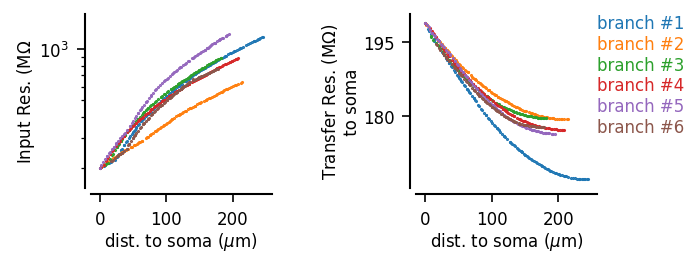

In [10]:
from electrophysiological_props import plt, pt, np
R = np.load('../../data/detailed_model/Input-Resistance_MC.npy',
            allow_pickle=True).item()

bins = np.linspace(0, 180, 20)
fig, AX = plt.subplots(1, 2, figsize=(5,2))
plt.subplots_adjust(wspace=0.8, bottom=0.3, right=0.8)
for i, dist, rin, rt in zip(range(len(R['Rt'])), R['distance'], R['Rin'], R['Rt']):
    AX[0].plot(dist, rin, 'o', ms=0.5, color=plt.cm.tab10(i))
    AX[1].plot(dist, rt, 'o', ms=0.5, color=plt.cm.tab10(i))
    pt.annotate(AX[1], i*'\n'+'branch #%i' % (i+1), (1,1), va='top', color=plt.cm.tab10(i))
pt.set_plot(AX[0], xlabel='dist. to soma ($\mu$m)',
            ylabel='Input Res. (M$\Omega$', yscale='log')
pt.set_plot(AX[1], xlabel='dist. to soma ($\mu$m)',
            ylabel='Transfer Res. (M$\Omega$)\n to soma ')
fig.savefig('../../figures/detailed_model/Resistance-Profile_BC.svg')